# Carbon Price Forecasting

## Introduction

> Tell us what the future holds, so we may know that you are gods. (Isaiah 41:23)

In this project, I forecast the price of carbon at which it is traded in carbon markets, or Emissions Trading Systems (ETS). The data is sourced from the [World Carbon Pricing Database](https://github.com/g-dolphin/WorldCarbonPricingDatabase/tree/master), compiled by Dolphin and Xiahou, economics PhD researchers. It is updated by an active userbase on Github. The exchange rate between national currencies and USD is sourced from the [U.S. Treasury's website](https://fiscaldata.treasury.gov/datasets/treasury-reporting-rates-exchange/treasury-reporting-rates-of-exchange) and the corresponding currency code from [IBAN](https://www.iban.com/currency-codes)'s website.

The idea of forecasting carbon prices came from a podcast I listened to called TILclimate, presented by the MIT Environmental Solutions Initiative, on the topic of carbon offsets and whether they were truly effective. With analysts predicting it could be a [$100 billion market](https://www.wsj.com/articles/rebuilding-trust-in-carbon-offsets-faces-uphill-battle-d7811603?mod=hp_minor_pos17) by 2030, it's important to ensure that the capital is invested in projects that can make a meaningful difference in removing carbon from our atmosphere.

While the goal isn't to determine whether those projects accurately capture the carbon they say they do, which would be an interesting project to tackle in itself, we look at the trading demand for carbon credits by predicting carbon prices over time, a market that has the power of shaping our livelihoods. Let's get started!

## Data Pre-Processing

In [ ]:
!pip install pandas --upgrade

In [22]:
# import packages
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# url used to parse HTML text using BeautifulSoup
base_url = 'https://github.com/g-dolphin/WorldCarbonPricingDatabase/tree/master/_dataset/data/CO2/national/'
# url used to read the content of the files from Github
file_url = 'https://raw.githubusercontent.com/g-dolphin/WorldCarbonPricingDatabase/master/_dataset/data/CO2/national/'

result = requests.get(base_url)
json_result = json.loads(result.text)

country_files = []
[country_files.append(file_url + country_file['name']) for country_file in json_result['payload']['tree']['items']]    

# while loop implementation, just for fun!
# index = 0

# while index < len(json_result['payload']['tree']['items']):
#     country_files.append(file_url + json_result['payload']['tree']['items'][index]['name'])
#     index+=1

print(country_files[0])

https://raw.githubusercontent.com/g-dolphin/WorldCarbonPricingDatabase/master/_dataset/data/CO2/national/wcpd_co2_Afghanistan.csv


In [8]:
carbon_df = pd.DataFrame()

for country_file in country_files:
    data = pd.read_csv(country_file)
    data = data.astype({'tax': 'int32', 'ets': 'int32', 'tax_rate_incl_ex_clcu': 'float', 'ets_price': 'float', 'tax_curr_code': 'str'})
    carbon_df = pd.concat([carbon_df, data], axis=0)

In [15]:
carbon_df = carbon_df.dropna(subset=['ets_price'])

In [36]:
carbon_df.drop(carbon_df.columns[carbon_df.apply(lambda col: col.isna().sum() == carbon_df.shape[0])], inplace=True, axis=1)

In [52]:
exch_rate_df = pd.read_csv('/Users/chloelubin/carbon_price_forecasting/_datasets/exchange_rate_2005_2022.csv')

carbon_df = pd.merge(
    carbon_df, exch_rate_df, how='left', left_on=['year', 'ets_curr_code'], right_on=['effective_year', 'country_code']
)

In [58]:
carbon_df['ets_price_usd'] = carbon_df['ets_price'] / carbon_df['exchange_rate']

In [59]:
carbon_df.dtypes

jurisdiction              object
year                       int64
ipcc_code                 object
Product                   object
tax                        int32
ets                        int32
tax_id                    object
tax_rate_excl_ex_clcu    float64
tax_ex_rate              float64
tax_rate_incl_ex_clcu    float64
tax_curr_code             object
ets_id                    object
ets_price                float64
ets_curr_code             object
recorded_date_x           object
country_name_x            object
country_code_x            object
exchange_rate_x          float64
effective_date_x          object
effective_year_x         float64
ets_price_usd            float64
recorded_date_y           object
country_name_y            object
country_code_y            object
exchange_rate_y          float64
effective_date_y          object
effective_year_y         float64
recorded_date             object
country_name              object
country_code              object
exchange_r

In [70]:
carbon_df.jurisdiction.unique()

array(['EUR', 'CNY', 'KZT', 'KRW', 'NZD', 'CHF', 'GBP'], dtype=object)

In [17]:
carbon_df.describe()

,year,tax,ets,tax_rate_excl_ex_clcu,tax_ex_rate,tax_rate_incl_ex_clcu,ets_price,ets_2_id,ets_2_price,ets_2_curr_code
count,43703.000000,43703.000000,43703.0,4941.000000,5008.000000,4941.000000,43703.000000,0.0,0.0,0.0
mean,2014.112807,0.114592,1.0,106.929135,0.039173,68.785893,349.509261,NaN,NaN,NaN
std,5.009149,0.318532,0.0,325.995177,0.174870,262.278894,2793.133980,NaN,NaN,NaN
min,2005.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,2010.000000,0.000000,1.0,1.890000,0.000000,1.890000,5.950000,NaN,NaN,NaN
50%,2014.000000,0.000000,1.0,12.000000,0.000000,12.000000,14.340000,NaN,NaN,NaN
75%,2018.000000,0.000000,1.0,27.622137,0.000000,27.622137,24.760000,NaN,NaN,NaN
max,2022.000000,1.000000,1.0,4235.000000,0.900000,4235.000000,30163.910000,NaN,NaN,NaN


In [19]:
carbon_df.shape

(43703, 17)

In [67]:
carbon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43703 entries, 0 to 43702
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   jurisdiction           43703 non-null  object 
 1   year                   43703 non-null  int64  
 2   ipcc_code              43703 non-null  object 
 3   Product                31671 non-null  object 
 4   tax                    43703 non-null  int32  
 5   ets                    43703 non-null  int32  
 6   tax_id                 5008 non-null   object 
 7   tax_rate_excl_ex_clcu  4941 non-null   float64
 8   tax_ex_rate            5008 non-null   float64
 9   tax_rate_incl_ex_clcu  4941 non-null   float64
 10  tax_curr_code          43703 non-null  object 
 11  ets_id                 43703 non-null  object 
 12  ets_price              43703 non-null  float64
 13  ets_curr_code          43703 non-null  object 
 14  recorded_date_x        42305 non-null  object 
 15  co

In [37]:
carbon_df.Product.unique()

array(['Coal', 'Natural gas', 'Oil', nan], dtype=object)

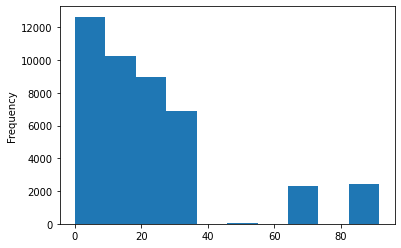

In [72]:
carbon_df.ets_price_usd.plot.hist(bins=10, alpha=0.5);

In [ ]:
carbon_df.to_csv('carbon_price_all_countries.csv', index=False)

## Exploratory Data Analysis

## Data Modeling

## Model Diagnostics

## Conclusion

## References

- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9859446/
